In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths to dataset
train_dir = '/Users/giripragada/Downloads/chest_xray/train'
test_dir = '/Users/giripragada/Downloads/chest_xray/test'
val_dir = '/Users/giripragada/Downloads/chest_xray/val'





In [3]:
# Image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Function to load and preprocess images
def load_and_preprocess_images(data_dir, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    data = []
    labels = []
    
    # Loop through the subdirectories (i.e., classes) in the data directory
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)
        if os.path.isdir(label_path):
            label = 0 if label_dir == 'NORMAL' else 1  # Label 0 for Normal, 1 for Pneumonia
            
            # Loop through each image in the current label directory
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                img = cv2.imread(img_path)
                
                if img is not None:
                    # Resize image to uniform size
                    img_resized = cv2.resize(img, target_size)
                    data.append(img_resized)
                    labels.append(label)

    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels



In [5]:
# Load training, testing, and validation data
train_data, train_labels = load_and_preprocess_images(train_dir)
test_data, test_labels = load_and_preprocess_images(test_dir)
val_data, val_labels = load_and_preprocess_images(val_dir)

# Normalize pixel values to range [0, 1]
train_data = train_data / 255.0
test_data = test_data / 255.0
val_data = val_data / 255.0

# Check the shapes of the loaded datasets
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")
print(f"Validation data shape: {val_data.shape}")

Training data shape: (5216, 224, 224, 3)
Testing data shape: (624, 224, 224, 3)
Validation data shape: (16, 224, 224, 3)


In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, BatchNormalization, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Reshape data for deep learning
train_data = train_data.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 3)  # 3 for RGB channels
test_data = test_data.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 3)
val_data = val_data.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 3)

# Initialize ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
        rotation_range=30,
        zoom_range=0.2,
        rescale=1./255  # Rescale to normalize pixel values between 0 and 1
)

train_generator = datagen.flow(train_data, train_labels, batch_size=32)
val_generator = ImageDataGenerator(rescale=1./255).flow(val_data, val_labels, batch_size=32)
test_generator = ImageDataGenerator(rescale=1./255).flow(test_data, test_labels, batch_size=32)



In [9]:

from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile with Adam optimizer
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,801 (24.86 MB)

 Trainable params: 6,516,353 (24.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [11]:

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-5)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the Model
history = model.fit(
    train_generator,
    epochs=12,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]
)

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100}%")



/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.7351 - loss: 3.3966 - val_accuracy: 0.5000 - val_loss: 2.9734 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.8186 - loss: 0.7573 - val_accuracy: 0.5000 - val_loss: 4.7440 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.8224 - loss: 0.6470 - val_accuracy: 0.5000 - val_loss: 1.7338 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.8633 - loss: 0.5947 - val_accuracy: 0.5000 - val_loss: 1.2199 - learning_rate: 0.0010
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.8781 - loss: 0.5861 - val_accuracy: 0.5000 - val_loss: 394.2542 - learning_rate: 0.0010
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.8721 - loss: 0.6165 - val_accuracy: 0.5000 - val_loss: 150.7174 - learning_rate: 0.0010
Epoch 7/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.8881 - loss

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step
              precision    recall  f1-score   support

           0       0.38      1.00      0.55       234
           1       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


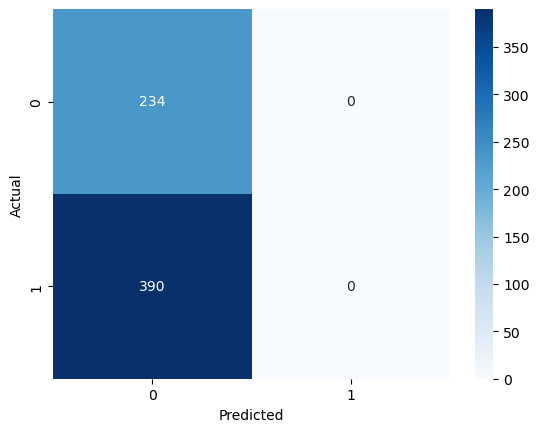

In [13]:
# Confusion Matrix and Classification Report
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype("int32")
print(classification_report(test_labels, y_pred_classes))
cm = confusion_matrix(test_labels, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


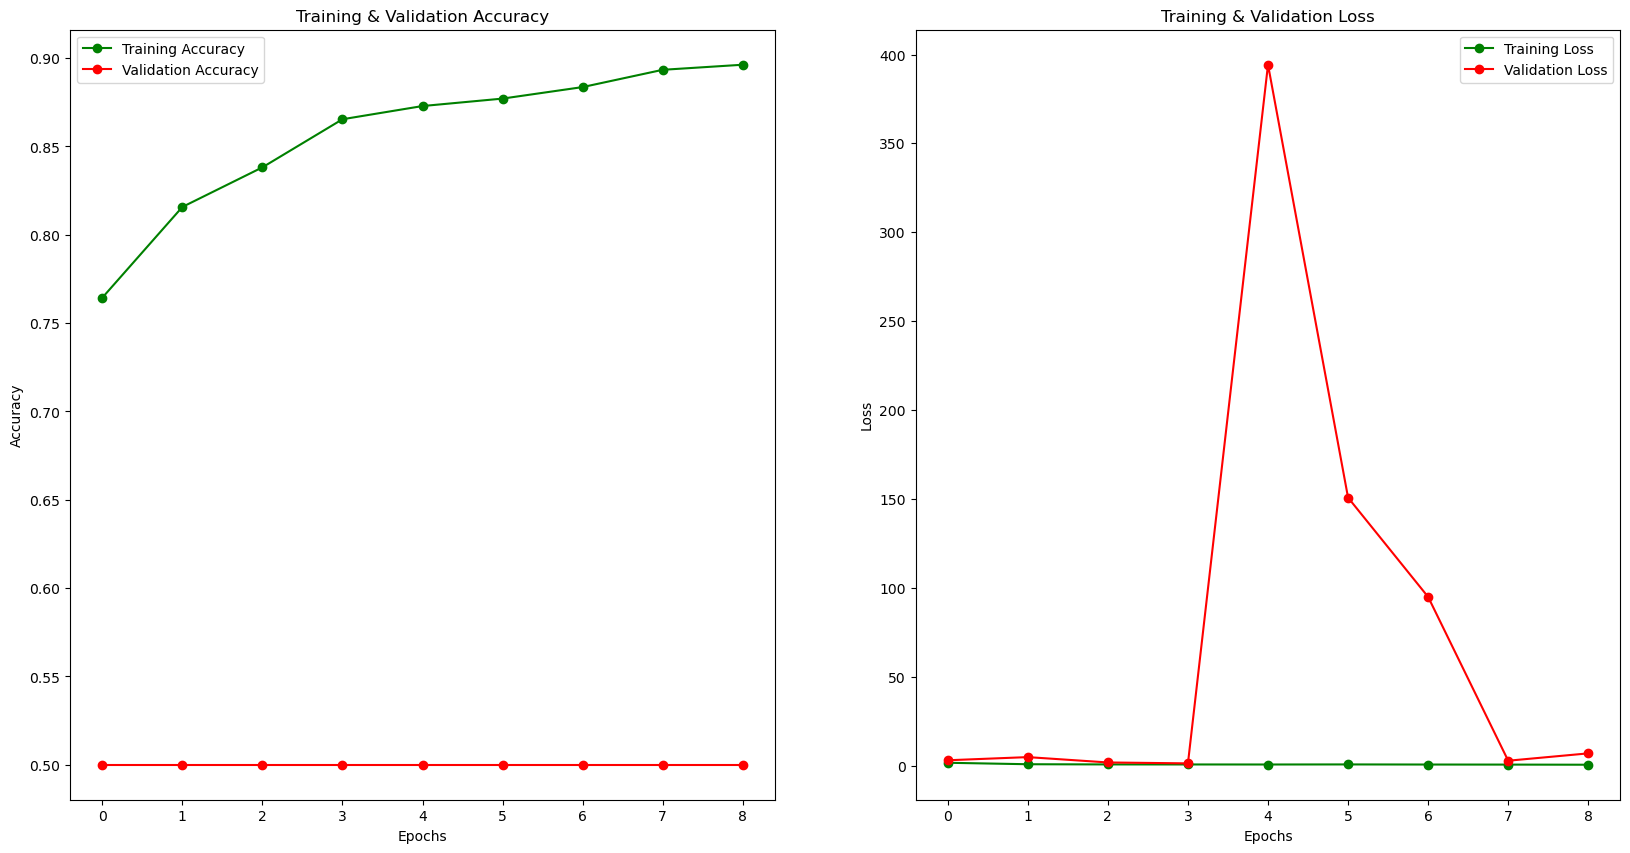

In [15]:
# Dynamically set epochs based on history length
epochs = [i for i in range(len(history.history['accuracy']))]

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plot accuracy
ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

# Plot loss
ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()


In [17]:
# Predictions and classification report
predictions = model.predict(test_data)
predictions = (predictions > 0.5).astype(int)  # Converting probabilities to binary labels

print(classification_report(test_labels, predictions, target_names=['Normal', 'Pneumonia']))

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step
              precision    recall  f1-score   support

      Normal       0.48      0.96      0.64       234
   Pneumonia       0.94      0.37      0.53       390

    accuracy                           0.59       624
   macro avg       0.71      0.67      0.58       624
weighted avg       0.77      0.59      0.57       624



In [19]:
# Visualize correct predictions
correct = np.nonzero(predictions.flatten() == test_labels)[0]
incorrect = np.nonzero(predictions.flatten() != test_labels)[0]


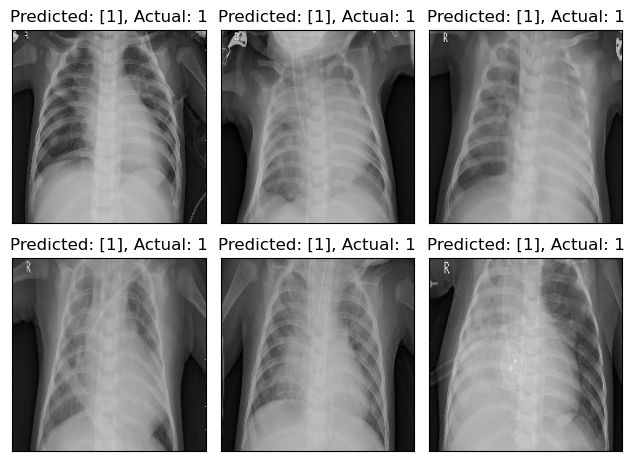

In [21]:
# Show 6 correct predictions
i = 0
for c in correct[:6]:
    plt.subplot(2, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_data[c], cmap="gray")
    plt.title(f"Predicted: {predictions[c]}, Actual: {test_labels[c]}")
    plt.tight_layout()
    i += 1


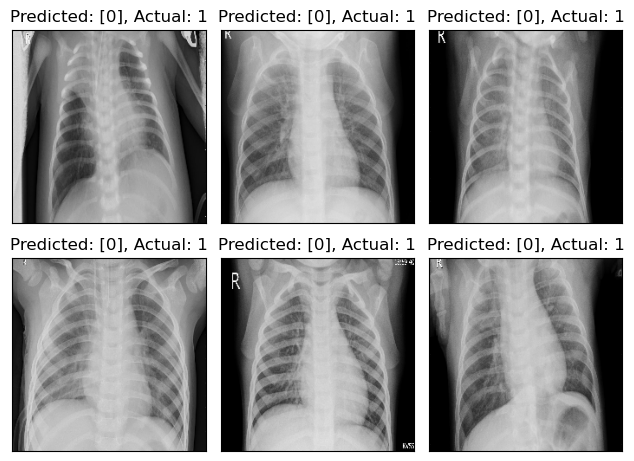

In [23]:
# Show 6 incorrect predictions
i = 0
for c in incorrect[:6]:
    plt.subplot(2, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_data[c], cmap="gray")
    plt.title(f"Predicted: {predictions[c]}, Actual: {test_labels[c]}")
    plt.tight_layout()
    i += 1

plt.show()